In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib as plt
import itertools as it
from analysis_utils import *

In [2]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

# Setup

In [28]:
EXPERIMENT = 5

os.makedirs(f'stats/{EXPERIMENT}', exist_ok=True)
def write_tex(name, tex):
    file = f"stats/{EXPERIMENT}/{name}.tex"
    with open(file, "w+") as f:
        f.write(str(tex) + r"\unskip")
    print(f'wrote "{tex}" to "{file}"')

data = get_data(EXPERIMENT)
pdf = data['participants'].set_index('pid').copy()
full_pdf = pdf.copy()
mdf = data['trials'].set_index('pid').copy()
mdf.trial_time /= 1000
mdf['clicked'] = mdf.n_clicks > 0

if EXPERIMENT == 3:
    pdf.query('completed_1', inplace=True)
else:
    pdf.query('completed', inplace=True)
    

if EXPERIMENT == 4:
    fb_namer = {
        (0, 0): 'none',
        (1, 0): 'info_only',
        (0, 1): 'reward_only',
        (1, 1): 'both'
    }
    pdf['feedback'] = pdf.apply(lambda row: fb_namer[row.information, row.reward], axis=1)
    mdf['information'] = pdf.information
    mdf['reward'] = pdf.reward
    fb_order = list(fb_namer.values())
elif EXPERIMENT == 6:
    pdf.rename(columns={'constantTest': 'constant_test'}, inplace=True)
    mdf['constant_test'] = pdf.constant_test
    pdf['feedback'] = 'meta'
    mdf['feedback'] = 'meta'
else:
    fb_order = [fb for fb in ['none', 'action', 'meta'] if fb in set(pdf.feedback)]

## Demographics

In [29]:
pids = list(pdf.index.unique())
sdf = data['survey'].query('pid == @pids').copy()
if not isinstance(sdf.responses.iloc[0], dict):
    sdf = sdf.loc[~sdf.responses.isna()]
    sdf.responses = sdf.responses.apply(ast.literal_eval)

if EXPERIMENT == 3:
    demo = sdf.loc[sdf.responses.apply(len) == 3].set_index('pid').responses
    age = demo.apply(get('Q1'))
    gender = demo.apply(get('Q2'))
else:
    demo = sdf.loc[sdf.responses.apply(len) == 2].set_index('pid').responses
    age = demo.apply(get('Q0'))
    gender = demo.apply(get('Q1'))
    
gender = gender.str.lower()
age = age.apply(excepts(ValueError, int, lambda _: None))

write_tex('mean-age', f'{age.mean():.2f}')
write_tex('min-age', str(age.min()))
write_tex('max-age', str(age.max()))

regularize = {
    'man': 'male',
    'woman': 'female',
    'f': 'female',
    'm': 'male',
}
gender = gender.apply(lambda x: regularize.get(x.strip(), x))
write_tex("N-female", str(gender.value_counts()['female']))

write_tex("N-total", f"${len(pdf)}$")
for fb, n in pdf.feedback.value_counts().items():
    write_tex(f"N-{fb}", f"${n}$")

wrote "36.25" to "stats/5/mean-age.tex"
wrote "22" to "stats/5/min-age.tex"
wrote "67" to "stats/5/max-age.tex"
wrote "25" to "stats/5/N-female.tex"
wrote "$61$" to "stats/5/N-total.tex"
wrote "$31$" to "stats/5/N-meta.tex"
wrote "$30$" to "stats/5/N-none.tex"


In [30]:
if EXPERIMENT == 3:
    dropped = pdf.query('not completed').feedback.value_counts()
    rate = dropped / pdf.feedback.value_counts()
    for fb in fb_order:
        write_tex(f'N-drop-{fb}', dropped[fb])
        write_tex(f'drop-rate-{fb}', f'${rate[fb]*100:.1f}\%$')
    write_tex('return-rate', f'${pdf.completed.mean()*100:.1f}\%$')
    write_tex('return-N', f'${pdf.completed.sum()}$')
    pdf.query('completed', inplace=True)
    
pd.Series(pdf.index).to_csv(f'pids/{EXPERIMENT}.csv', index=False, header=False)

In [31]:
completed = list(pdf.index)
mdf.reset_index(inplace=True)
mdf.query('pid == @completed', inplace=True)
mdf.set_index('pid', inplace=True)

pdf.feedback = pd.Categorical(pdf.feedback, fb_order, ordered=True)    
mdf['feedback'] = pdf.feedback
block_mean = mdf.groupby(['block', 'pid']).score.mean()
for b in ['training', 'test']:
    pdf[b] = block_mean[b]

In [32]:
small_leaves = {3,4,7,8,11,12}
transfer_leaves = {5, 6, 7, 9, 10, 11, 16, 17, 18, 20, 21, 22, 27, 28, 29, 31, 32, 33}

def clicked_leaf_first(row):
    if not row.clicks:
        return False
    first = row.clicks[0]
    transfer =  EXPERIMENT in (2, 3) and row.block == "test"
    leaves = transfer_leaves if transfer else small_leaves
    return first in leaves

mdf['backward'] = mdf.apply(clicked_leaf_first, axis=1)

## Setup Plotting 

In [33]:
figure = Figures(path=f'figs/{EXPERIMENT}', formats=['pdf', 'png']).plot

sns.set_style('whitegrid')
blue, orange = sns.color_palette('tab10')[:2]
gray = (0.5,)*3
red = (1, 0.3, 0.4)
yellow = (1, 0.9, 0.4)
palette = {
    'none': gray,
    'action': blue,
    'meta': orange,
    'info_only': red,
    'reward_only': yellow,
    'both': orange,
}

palette = {
    'none': gray,
    'action': blue,
    'meta': orange,
    'info_only': red,
    'reward_only': yellow,
    'both': orange,
}

nice_names = {
    'meta': 'Metacognitive',
    'action': 'Action',
    'none': 'None',
    'feedback': 'Feedback',
    'info_only': 'Information\nOnly',
    'reward_only': 'Reward\nOnly',
    'both': 'Information &\nReinforcement',
    'score': 'Average Score',
    'backward': 'Proportion Planning Backward'
}

def reformat_labels(ax=None):
    ax = ax or plt.gca()
    labels = [t.get_text() for t in ax.get_xticklabels()]
    new_labels = [nice_names.get(lab, lab) for lab in labels]
    ax.set_xticklabels(new_labels)
    
def reformat_legend(ax=None):
    if ax is None:
        ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    print([nice_names.get(l, l).replace('\n', ' ') for l in labels])
    ax.legend(handles=handles, labels=[nice_names.get(l, l).replace('\n', ' ') 
                                       for l in labels])
    
def plot_block_changes():
    block_changes = mdf.loc[1].block.apply(Labeler()).diff().reset_index().query('block == 1').index
    for t in block_changes:
        plt.axvline(t-0.5, c='k', ls='--')

from datetime import datetime
# os.makedirs(f'stats/{EXPERIMENT}/', exist_ok=True)
def result_file(name, ext='tex'):
    file = f'stats/{EXPERIMENT}-{name}.{ext}'
#     with open(file, 'w+') as f:
#         timestamp = datetime.now().strftime('Created on %m/%d/%y at %H:%M:%S\n\n')
#         f.write(timestamp)
    return file

# Test score

figs/5/test.pdf
figs/5/test.png


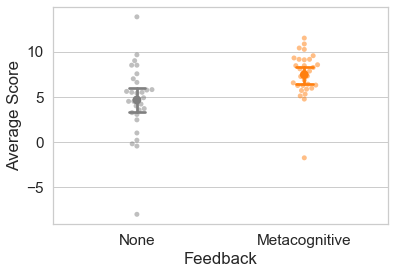

In [34]:
@figure()
def plot_test():
    if EXPERIMENT == 4:
        plt.figure(figsize=(12,4))

    sns.swarmplot('feedback', 'test', data=pdf, palette=palette, alpha=0.5, order=fb_order)
    sns.pointplot('feedback', 'test', data=pdf, palette=palette, order=fb_order, 
                  scale=1, capsize=0.1, markers='o')
    plt.xlabel('Feedback')
    plt.ylabel(nice_names['score'])
    test = 'Test' if EXPERIMENT == 1 else 'Transfer'
    reformat_labels()
    

## Kruskal

In [35]:
rdf = pdf[['test', 'feedback']].copy()

In [36]:
%%R -i rdf -o out
out = kruskal.test(test ~ feedback, data=rdf)

In [37]:
out = dict(out.items())
df = out["parameter"][0]
p = pval(out["p.value"][0])
stat = out["statistic"][0]
write_tex('score-kruskal', rf'$\chi^2({df}) = {stat:.3f}, {p}$')
# p = pvalue(out

wrote "$\chi^2(1) = 14.125, p < .001$" to "stats/5/score-kruskal.tex"


## Bootstrapping

### Means

In [38]:
N_BOOT = 10000
test_score = pdf.set_index('feedback').test

def ci(xs):
    return np.quantile(xs, [0.025, 0.975])

def boot_means(n=N_BOOT):
    r = {}
    for fb in fb_order:
        x = test_score.loc[fb]
        means = [x.sample(frac=1, replace=True).mean() for _ in range(n)]
        r[fb] = np.array(means)
    return r

In [39]:
bm = boot_means()
for fb in fb_order:
    x = test_score.loc[fb].mean()
    a, b = ci(bm[fb])
    if fb == 'none':
        tex = (rf'${x:.2f}$ points/trial (95\% CI: [${a:.2f}$, ${b:.2f}$])')
    else:
        tex = (rf'${x:.2f}$ points/trial; 95\% CI: [${a:.2f}$, ${b:.2f}$]')
    write_tex(f'mean-{fb}', tex)

wrote "$4.65$ points/trial (95\% CI: [$3.21$, $5.96$])" to "stats/5/mean-none.tex"
wrote "$7.44$ points/trial; 95\% CI: [$6.54$, $8.24$]" to "stats/5/mean-meta.tex"


### Differences by permutation test

In [40]:
def null_mean_diff_samples(c1, c2, n=N_BOOT):
    r = []
    x = test_score.copy()
    for i in range(n):
        np.random.shuffle(x.values)
        r.append(x.loc[c1].mean() - x.loc[c2].mean())
    return np.array(r)

#         x = test_score.sample(n=n_fb[c1], replace=True)
#         y = test_score.sample(n=n_fb[c2], replace=True)
#         r.append(x.mean() - y.mean())

def report(c1, c2, n=N_BOOT):
    actual_diff = test_score.loc[c1].mean() - test_score.loc[c2].mean()
    null_diff = null_mean_diff_samples(c1, c2, n=n)
#     p = (1 + np.sum(abs(null_diff) >= abs(actual_diff))) / (n+1)
    p = np.mean(abs(null_diff) >= abs(actual_diff))
    write_tex(f'permutation-{c1}-{c2}', f'${pval(p)}$')

if EXPERIMENT == 4:
    report('both', 'none')
    report('info_only', 'none')
    report('reward_only', 'none')
    report('both', 'reward_only')
    report('both', 'info_only')
else:
    report('meta', 'none')
    if 'action' in fb_order:
        report('meta', 'action')
        report('action', 'none')

wrote "$p < .001$" to "stats/5/permutation-meta-none.tex"


# Learning curves

['Feedback', 'None', 'Metacognitive']
figs/5/learning_curve_score.pdf
figs/5/learning_curve_score.png


<function analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

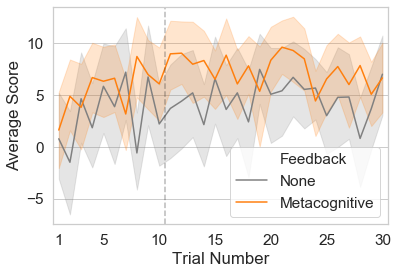

In [41]:
def learning_curve(var):
    df = mdf.copy()
    df.trial_index += 1
    sns.lineplot('trial_index', var, hue='feedback', 
                 data=df, hue_order=fb_order, palette=palette)
    plt.ylabel(nice_names[var])
    plt.xlabel('Trial Number')
    plt.gca().grid(axis='x')
    split = mdf.query('block == "training"').trial_index.max()
    plt.axvline(split+1.5, c='k', ls='--', alpha=0.3)
    plt.xticks([1, *range(5, 31, 5)])
    plt.xlim(df.trial_index.min()-0.5, df.trial_index.max()+0.5)
    reformat_legend()
    
figure(var='score')(learning_curve)

['Feedback', 'None', 'Metacognitive']
figs/5/learning_curve_backward.pdf
figs/5/learning_curve_backward.png


<function analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

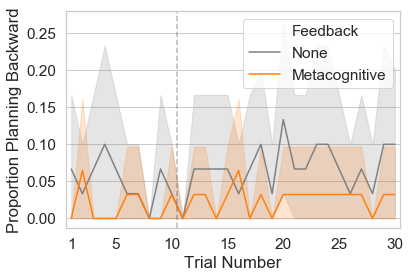

In [42]:
figure(var='backward')(learning_curve)

# Process

## Summary in test block

In [43]:
def report_ratio(df, key):
    name = key.replace('_', '-')
    X = df.groupby(['feedback', key]).apply(len)
    rate = 100 * df.groupby('feedback')[key].mean()

    for c in fb_order:
        r = rate[c]
        write_tex(f'{name}-{c}-percent', f"${r:.1f}$\%")


report_ratio(mdf.query('block == "test"').copy(), 'backward')

wrote "$6.8$\%" to "stats/5/backward-none-percent.tex"
wrote "$2.6$\%" to "stats/5/backward-meta-percent.tex"


## Mediation

In [19]:
rdf = mdf.query('block == "test"').copy().rename(columns={'information': 'info'})
# rdf['feedback'] = (rdf.feedback != 'none').astype(int)

if EXPERIMENT == 4:
    factors = ['info', 'reward']
    for c in factors:
        rdf[c] = rdf[c].astype(float)
else:
    factors = ['action', 'meta']
    fb = rdf.pop('feedback')
    for c in factors:
        rdf[c] = (fb == c).astype(int)

rdf['clicked'] = rdf.clicked.astype(int)
rdf = rdf[[*factors, 'backward', 'clicked', 'n_clicks', 'score', 'trial_index', 'stim_i']].reset_index()
rdf.backward.fillna(0, inplace=True)
# rdf.trial_index = rdf.trial_index.astype(float)
# rdf.query('action == 0', inplace=True)
rdf = rdf.groupby('pid').mean()
rdf.trial_index -= rdf.trial_index.min()

In [20]:
%%R -i rdf -o score
fit = lm(score ~ backward, data=rdf)
score = summary(fit)
score


Call:
lm(formula = score ~ backward, data = rdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.959  -3.473   0.393   3.260  34.909 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    7.691      1.020    7.54 3.19e-13 ***
backward      31.716      1.182   26.82  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.335 on 399 degrees of freedom
Multiple R-squared:  0.6433,	Adjusted R-squared:  0.6424 
F-statistic: 719.4 on 1 and 399 DF,  p-value: < 2.2e-16



In [21]:
score = dict(score.items())
df = score['df'][1]
est, std, t, p = score['coefficients'][1]
write_tex(f'score-backward', f'${est:.3f}$')
write_tex(f'score-backward-test', f'$t({df}) = {t:.3f}$, ${pval(p)}$')

wrote "$31.716$" to "stats/4/score-backward.tex"
wrote "$t(399) = 26.822$, $p < .001$" to "stats/4/score-backward-test.tex"


In [22]:
%%R -i rdf -i EXPERIMENT -o back -o med_out
library(mediation)

if (EXPERIMENT == 1) {
    back_fit = lm(backward ~ action + meta, data=rdf)
    score_fit = lm(score ~ backward + action + meta, data=rdf)
} else {
    back_fit = lm(backward ~ meta, data=rdf)
    score_fit = lm(score ~ backward + meta, data=rdf)
}
med_out = mediate(back_fit, score_fit, treat="meta", mediator="backward")
back = summary(back_fit)
summary(med_out)

R[write to console]: Loading required package: MASS

R[write to console]: Loading required package: Matrix

R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: sandwich

R[write to console]: mediation: Causal Mediation Analysis
Version: 4.4.7


R[write to console]: Error in eval(predvars, data, env) : object 'meta' not found
Calls: <Anonymous> ... eval -> <Anonymous> -> model.frame.default -> eval -> eval




Error in eval(predvars, data, env) : object 'meta' not found
Calls: <Anonymous> ... eval -> <Anonymous> -> model.frame.default -> eval -> eval


In [23]:
back = dict(back.items())
df = back['df'][1]
for i, name in enumerate(fb_order[1:], start=1):
    est, std, t, p = back['coefficients'][i]
    write_tex(f'backward-lm-{name}', f'$t({df}) = {t:.3f}$, ${pval(p)}$')

NameError: name 'back' is not defined

In [ ]:
names = {
    'acme': 'd0',
    'ade': 'z0',
    'total': 'tau',
    'prop': 'n0',
}
med = dict(med_out.items())

for k, v in names.items():
    est = med[v + ('.coef' if v == 'tau' else '')][0]
    lo, hi = med[v+'.ci']
    p = med[v+'.p'][0]
    write_tex(f'mediation-{k}', f'{est:.3f}')
    write_tex(f'mediation-{k}-ci', f'95\% CI: [{lo:.3f}, {hi:.3f}], ${pval(p)}$')

In [ ]:
print("Success!")